# DSE 230 - Final Project Notebook - Biometric Data - Classification

### Requirements

In [15]:
### package requirements
# matplotlib==3.1.2
# numpy==1.19.5
# pandas==1.2.4
# pyspark==3.1.1
# python-dateutil==2.8.1
# scikit-learn==0.24.1
# scipy==1.6.2
# seaborn==0.11.1

### Import Required Packages

In [16]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import decode, regexp_replace, lit
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, LinearSVC, OneVsRest, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from random import sample
from scipy.io import arff
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

### Set Global Seed

In [17]:
seed = 42

## Download Data from Web

In [18]:
# go get data

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip
!unzip -o -j "wisdm-dataset.zip" "wisdm-dataset/arff_files/*"
!unzip -o -j "wisdm-dataset.zip" "wisdm-dataset/activity_key.txt"

--2021-06-04 19:45:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 309713877 (295M) [application/x-httpd-php]
Saving to: ‘wisdm-dataset.zip.1’

wisdm-dataset.zip.1 100%[===================>] 295.37M  28.0MB/s    in 11s     

2021-06-04 19:45:20 (27.7 MB/s) - ‘wisdm-dataset.zip.1’ saved [309713877/309713877]

Archive:  wisdm-dataset.zip
  inflating: data_1610_gyro_phone.arff  
  inflating: data_1612_gyro_phone.arff  
  inflating: data_1637_gyro_phone.arff  
  inflating: data_1622_gyro_phone.arff  
  inflating: data_1604_gyro_phone.arff  
  inflating: data_1639_gyro_phone.arff  
  inflating: data_1621_gyro_phone.arff  
  inflating: data_1623_gyro_phone.arff  
  inflating: data_1640_gyro_phone.arff  
  inflating: data_1645_gyro_phone.arff

## Create All User-Defined Functions

In [19]:
def load_arffs(wildcard_path):
    
    # goes to local location (where the unzip terminal commands deposited arff files) 
    ## concatenates all files matching wildcard into a single dataframe
    arff_list = glob(wildcard_path)
    df = pd.DataFrame()
    for file in arff_list:
        data = arff.loadarff(file)
        df = pd.concat([df, pd.DataFrame(data[0])])
    print(df.shape)
    return df

In [20]:
def make_dataframes():   
    
    global df_accel_watch, df_accel_phone, df_gyro_watch, df_gyro_phone, activity_map
    
    # read in pre-computed attributes data
    df_accel_watch = load_arffs('data_*_accel_watch.arff')
    df_accel_phone = load_arffs('data_*_accel_phone.arff')
    df_gyro_watch = load_arffs('data_*_gyro_watch.arff')
    df_gyro_phone = load_arffs('data_*_gyro_phone.arff')
    
    # read in activity mapping doc to decode activity names
    activity_map = pd.read_table(
        'activity_key.txt',
        sep = ' = ',
        header = None,
        engine = 'python',
        names = ['activity_name', 'activity_id']
    ).set_index('activity_id')['activity_name'].to_dict()

In [21]:
def data_cleanup(df):
    df['"ACTIVITY"'] = [x.decode('utf-8') for x in df['"ACTIVITY"']]
    df['"class"'] = [x.decode('utf-8') for x in df['"class"']]

    return df

In [22]:
def run_cleanup():
    
    global df_accel_watch, df_accel_phone, df_gyro_watch, df_gyro_phone
    
    df_accel_watch = data_cleanup(df_accel_watch)
    df_accel_phone = data_cleanup(df_accel_phone)
    df_gyro_watch = data_cleanup(df_gyro_watch)
    df_gyro_phone = data_cleanup(df_gyro_phone)

In [24]:
def spark_preprocessing(spark_df):
    # remove na values
    before_drop = spark_df.count()
    spark_df = spark_df.dropna(how='any')
    after_drop = spark_df.count()

    print('{} rows dropped for having NA values'.format(before_drop - after_drop))
    
    # clean up column names
    for name in spark_df.schema.names:
        spark_df = spark_df.withColumnRenamed(name, name.replace('"', ''))

    # create feature vector column
    features = spark_df.columns[1:-4]
    assembler = VectorAssembler(inputCols=features, outputCol='featureVector')
    spark_df = assembler.transform(spark_df)

    # split data into test and training
    train_df, test_df = spark_df.randomSplit([.75,.25], seed=seed)

    # scale input data
    scaler = StandardScaler(inputCol='featureVector', outputCol='featureVector_scaled', withStd=True, withMean=True)
    scalerModel = scaler.fit(train_df)

    train_df = scalerModel.transform(train_df)
    test_df = scalerModel.transform(test_df)
    
    return train_df, test_df

In [25]:
def multiclassClassifier_oneVsRest_logisticRegression(train_data, test_data):
    # Classification - One v. Rest - Logistic Regression

    classifier = LogisticRegression(maxIter=1000)

    lr_ovr = OneVsRest(classifier=classifier)
    lr_model = lr_ovr.fit(train_data)
    lr_eval_data = lr_model.transform(test_data)

    lr_evaluator = MulticlassClassificationEvaluator(metricName=evaluation_metric)
    
    return lr_evaluator.evaluate(lr_eval_data)

In [26]:
def multiclassClassifier_oneVsRest_supportVectorClassifier(train_data, test_data):
    # Classification - One v. Rest - Support Vector Classifier

    classifier=LinearSVC(maxIter=100, regParam=.000000001) 

    svc_ovr = OneVsRest(classifier=classifier)
    svc_model = svc_ovr.fit(train_data)
    svc_eval_data = svc_model.transform(test_data)

    svc_evaluator = MulticlassClassificationEvaluator(metricName=evaluation_metric)
    return svc_evaluator.evaluate(svc_eval_data)

In [27]:
def multiclassClassifier_randomForest(train_data, test_data):
    # Classification - Random Forest

    rf = RandomForestClassifier(numTrees=30, maxDepth=10, seed=seed)

    rf_model = rf.fit(train_data)
    rf_eval_data = rf_model.transform(test_data)

    rf_evaluator = MulticlassClassificationEvaluator(metricName=evaluation_metric)
    return rf_evaluator.evaluate(rf_eval_data), rf_model, np.array(rf_eval_data.select('label', 'prediction').collect())

In [28]:
def classifier_ensemble(training_spark_data, testing_spark_data):
    
    # Set up data / variables for ML training
    train_data = training_spark_data
    test_data = testing_spark_data

    train_data = train_data.select(feature_col, label_col). \
                            withColumnRenamed(feature_col, 'features'). \
                            withColumnRenamed(label_col, 'label')
    test_data = test_data.select(feature_col, label_col). \
                          withColumnRenamed(feature_col, 'features'). \
                          withColumnRenamed(label_col, 'label')
    
    results = []
    
    start_time = time.time()
    ovr_lr = multiclassClassifier_oneVsRest_logisticRegression(train_data, test_data)
    ovr_lr_end = time.time()
    
    ovr_svm = multiclassClassifier_oneVsRest_supportVectorClassifier(train_data, test_data)
    ovr_svm_end = time.time()
    
    rf, rf_model, rf_prediction_array = multiclassClassifier_randomForest(train_data, test_data)
    rf_end = time.time()
    
    results = pd.DataFrame(np.array([
        ['Logistic Regression', ovr_lr, ovr_lr_end-start_time],
        ['Support Vector Classifier', ovr_svm, ovr_svm_end-ovr_lr_end],
        ['Random Forest', rf, rf_end-ovr_svm_end]
    ]), columns=['model', 'accuracy', 'training_time'])
    
    print('Best Model: ', results.iloc[np.argmax(results.iloc[:,1]),:], 'Total Run Time : {} seconds'.format(rf_end-start_time), sep='\n')
    return results, rf_model, rf_prediction_array

In [29]:
def generate_confusion_matrix(prediction_array, title):
    
    # create confusion matrix from the prediciton array
    ## array passed from classifier ensemble function
    ### format is true label, predicted label
    conf_matrix = confusion_matrix(y_true=prediction_array[:,0], y_pred=prediction_array[:,1])
    
    # create Seaborn settings
    sns.reset_defaults()
    sns.set(style='ticks')
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=150)
    sns.despine()

    sns.heatmap(
        # construct dataframe from confusion matrix and apply human readable class labels
        pd.DataFrame(
            conf_matrix, 
            index = activity_map.values(), 
            columns = activity_map.values()
        ),
        cbar = True,
        annot = True,
        fmt = 'd',
        annot_kws = {"fontsize": 'x-small'},
        linewidths = 0.1,
        cmap = 'viridis_r',
    )
    
    # apply title
    ax.set_title(title)
    fig.tight_layout()
    plt.close('all')
    
    #return heatmap to be printed
    return fig

## Import Data into Python

In [30]:
make_dataframes()
run_cleanup()

(18211, 93)
(23074, 93)
(16533, 93)
(17281, 93)


In [33]:
# combine all data frames and convert to numpy array

df = pd.concat([df_accel_watch, df_accel_phone, df_gyro_watch, df_gyro_phone])
df.shape

(75099, 93)

## Conduct Exploratory Data Analysis

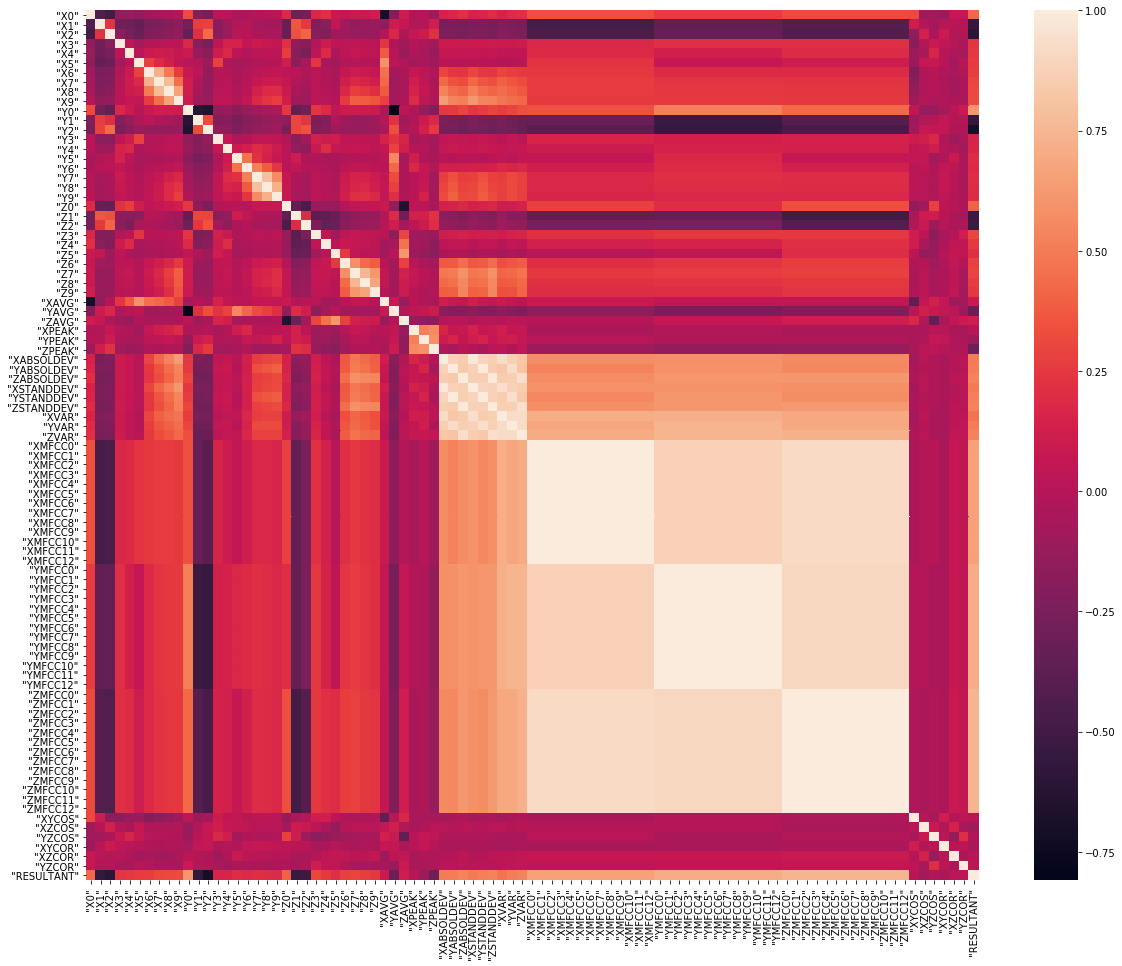

In [34]:
f, ax = plt.subplots(figsize=(20, 16))
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [35]:
df.columns

Index(['"ACTIVITY"', '"X0"', '"X1"', '"X2"', '"X3"', '"X4"', '"X5"', '"X6"',
       '"X7"', '"X8"', '"X9"', '"Y0"', '"Y1"', '"Y2"', '"Y3"', '"Y4"', '"Y5"',
       '"Y6"', '"Y7"', '"Y8"', '"Y9"', '"Z0"', '"Z1"', '"Z2"', '"Z3"', '"Z4"',
       '"Z5"', '"Z6"', '"Z7"', '"Z8"', '"Z9"', '"XAVG"', '"YAVG"', '"ZAVG"',
       '"XPEAK"', '"YPEAK"', '"ZPEAK"', '"XABSOLDEV"', '"YABSOLDEV"',
       '"ZABSOLDEV"', '"XSTANDDEV"', '"YSTANDDEV"', '"ZSTANDDEV"', '"XVAR"',
       '"YVAR"', '"ZVAR"', '"XMFCC0"', '"XMFCC1"', '"XMFCC2"', '"XMFCC3"',
       '"XMFCC4"', '"XMFCC5"', '"XMFCC6"', '"XMFCC7"', '"XMFCC8"', '"XMFCC9"',
       '"XMFCC10"', '"XMFCC11"', '"XMFCC12"', '"YMFCC0"', '"YMFCC1"',
       '"YMFCC2"', '"YMFCC3"', '"YMFCC4"', '"YMFCC5"', '"YMFCC6"', '"YMFCC7"',
       '"YMFCC8"', '"YMFCC9"', '"YMFCC10"', '"YMFCC11"', '"YMFCC12"',
       '"ZMFCC0"', '"ZMFCC1"', '"ZMFCC2"', '"ZMFCC3"', '"ZMFCC4"', '"ZMFCC5"',
       '"ZMFCC6"', '"ZMFCC7"', '"ZMFCC8"', '"ZMFCC9"', '"ZMFCC10"',
       '"ZMFCC11"', '

In [36]:
df.drop(df.iloc[:, 43:-8], inplace = True, axis = 1)
df.shape

(75099, 51)

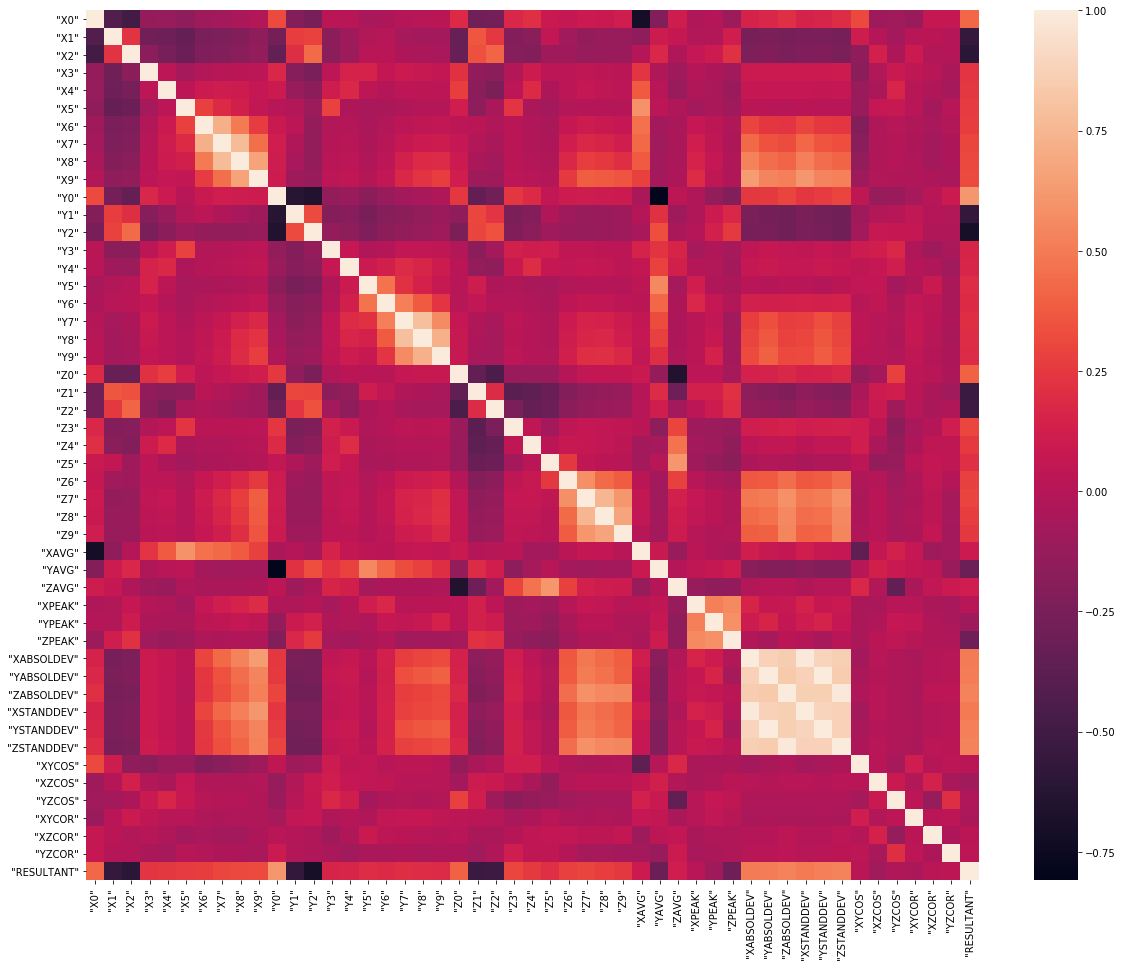

In [37]:
f, ax = plt.subplots(figsize=(20, 16))
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Spark Data Prep

In [38]:
# Initialize Spark Session
conf = pyspark.SparkConf().setAll([
    ('spark.master', 'local[*]'),
    ('spark.app.name', 'PySpark DSE230 Final')])

try: 
    if type(spark) == 'pyspark.sql.session.SparkSession':
        spark.stop()
        spark = SparkSession.builder.config(conf=conf).getOrCreate()
except:
    spark = SparkSession.builder.config(conf=conf).getOrCreate()

    print (spark.version, pyspark.version.__version__)

3.1.1 3.1.1


In [39]:
# convert Pandas dataframe to Spark dataframe

#spark_df = spark.createDataFrame(df)

#stringIndexer = StringIndexer(inputCol="ACTIVITY", outputCol="label")
#si_model = stringIndexer.fit(df)
#td = si_model.transform(df)
df.drop(df.iloc[:, 43:-8], inplace = True, axis = 1)

In [40]:
# separate data into individual descriptives data frames

spark_df_accel_watch = spark.createDataFrame(df_accel_watch.drop(df_accel_watch.iloc[:, 43:-8], axis = 1))
spark_df_gyro_watch = spark.createDataFrame(df_accel_phone.drop(df_accel_phone.iloc[:, 43:-8], axis = 1))
spark_df_accel_phone = spark.createDataFrame(df_gyro_watch.drop(df_gyro_watch.iloc[:, 43:-8], axis = 1))
spark_df_gyro_phone = spark.createDataFrame(df_gyro_phone.drop(df_gyro_phone.iloc[:, 43:-8], axis = 1))

# add descriptives of data type
spark_df_accel_watch = spark_df_accel_watch.withColumn('device_type', lit('watch')).withColumn('sensor_type', lit('accelerometer'))
spark_df_gyro_watch = spark_df_gyro_watch.withColumn('device_type', lit('watch')).withColumn('sensor_type', lit('gyroscope'))
spark_df_accel_phone = spark_df_accel_phone.withColumn('device_type', lit('phone')).withColumn('sensor_type', lit('accelerometer'))
spark_df_gyro_phone = spark_df_gyro_phone.withColumn('device_type', lit('phone')).withColumn('sensor_type', lit('gyroscope'))

#spark_df_gyro_watch = spark_df.select('*').where((spark_df.device_type == 'watch') & (spark_df.sensor_type == 'gyroscope'))
#spark_df_accel_phone = spark_df.select('*').where((spark_df.device_type == 'phone') & (spark_df.sensor_type == 'accelerometer'))
#spark_df_gyro_phone = spark_df.select('*').where((spark_df.device_type == 'phone') & (spark_df.sensor_type == 'gyroscope'))

In [41]:
# encode string classes to numerical values

stringIndexer = StringIndexer(inputCol='"ACTIVITY"', outputCol='label', stringOrderType ='alphabetAsc')
si_model = stringIndexer.fit(spark_df_accel_watch)

spark_df_accel_watch = si_model.transform(spark_df_accel_watch)
spark_df_gyro_watch = si_model.transform(spark_df_gyro_watch)
spark_df_accel_phone = si_model.transform(spark_df_accel_phone)
spark_df_gyro_phone = si_model.transform(spark_df_gyro_phone)

In [42]:
# conduct data pre-processing in Spark

train_df_accel_watch, test_df_accel_watch = spark_preprocessing(spark_df_accel_watch)
train_df_gyro_watch, test_df_gyro_watch = spark_preprocessing(spark_df_gyro_watch)
train_df_accel_phone, test_df_accel_phone = spark_preprocessing(spark_df_accel_phone)
train_df_gyro_phone, test_df_gyro_phone = spark_preprocessing(spark_df_gyro_phone)

0 rows dropped for having NA values
0 rows dropped for having NA values
0 rows dropped for having NA values
0 rows dropped for having NA values


## Spark Modeling / Predictions

In [43]:
%%time
# test which model performs best for each of the data descriptives

feature_col = 'featureVector_scaled'
label_col = 'label'
evaluation_metric = 'accuracy'

accel_watch_results, accel_watch_rfmodel, accel_watch_rf_prediction_array = classifier_ensemble(train_df_accel_watch, test_df_accel_watch)
gyro_watch_results, gyro_watch_rfmodel, gyro_watch_rf_prediction_array = classifier_ensemble(train_df_gyro_watch, test_df_gyro_watch)
accel_phone_results, accel_phone_rfmodel, accel_phone_rf_prediction_array = classifier_ensemble(train_df_accel_phone, test_df_accel_phone)
gyro_phone_results, gyro_phone_rfmodel, gyro_phone_rf_prediction_array = classifier_ensemble(train_df_gyro_phone, test_df_gyro_phone)

Best Model: 
model                 Random Forest
accuracy         0.7756988277727682
training_time    10.587776899337769
Name: 2, dtype: object
Total Run Time : 271.4555540084839 seconds
Best Model: 
model                 Random Forest
accuracy         0.6938847649346058
training_time     9.567112922668457
Name: 2, dtype: object
Total Run Time : 292.4785325527191 seconds
Best Model: 
model                 Random Forest
accuracy         0.6384405264464862
training_time     7.696694612503052
Name: 2, dtype: object
Total Run Time : 239.52949333190918 seconds
Best Model: 
model                 Random Forest
accuracy         0.4597156398104265
training_time     8.371504783630371
Name: 2, dtype: object
Total Run Time : 258.8946945667267 seconds
CPU times: user 13.3 s, sys: 4.85 s, total: 18.1 s
Wall time: 17min 42s


accel_watch_rfmodel## Visualize Model Performance

In [50]:
print(pd.DataFrame(accel_watch_rfmodel.featureImportances.toArray(), list(train_df_accel_watch.columns)[1:-6]).sort_values(0, ascending=False).sum())

0    1.0
dtype: float64


In [44]:
for model in [accel_watch_rfmodel, gyro_watch_rfmodel, accel_phone_rfmodel, gyro_phone_rfmodel]:
    print(pd.DataFrame(model.featureImportances.toArray(), list(train_df_accel_watch.columns)[1:-6]).sort_values(0, ascending=False)[:10].sum())
    print(pd.DataFrame(model.featureImportances.toArray(), list(train_df_accel_watch.columns)[1:-6]).sort_values(0, ascending=False).head(20))

0    0.683395
dtype: float64
                  0
RESULTANT  0.073232
YABSOLDEV  0.057494
YSTANDDEV  0.046924
YPEAK      0.043863
XAVG       0.041168
XSTANDDEV  0.037494
ZSTANDDEV  0.036008
X0         0.034245
XABSOLDEV  0.032608
ZAVG       0.032414
YAVG       0.031223
XPEAK      0.029295
X5         0.028863
ZABSOLDEV  0.028185
Z5         0.026477
ZPEAK      0.022797
Z9         0.022034
XYCOS      0.020027
X6         0.019538
XYCOR      0.019506
0    0.729889
dtype: float64
                  0
YSTANDDEV  0.071182
YABSOLDEV  0.066406
XABSOLDEV  0.054525
YAVG       0.051168
RESULTANT  0.049810
ZABSOLDEV  0.045890
XSTANDDEV  0.043781
Z1         0.039235
ZSTANDDEV  0.035487
XAVG       0.034541
ZAVG       0.032629
XYCOS      0.029551
YPEAK      0.027561
XPEAK      0.024189
YZCOS      0.022720
Z2         0.021738
ZPEAK      0.020959
XZCOS      0.020368
Y3         0.020139
X1         0.018012
0    0.778127
dtype: float64
                  0
XPEAK      0.068192
YABSOLDEV  0.067843
YSTANDDEV  0.

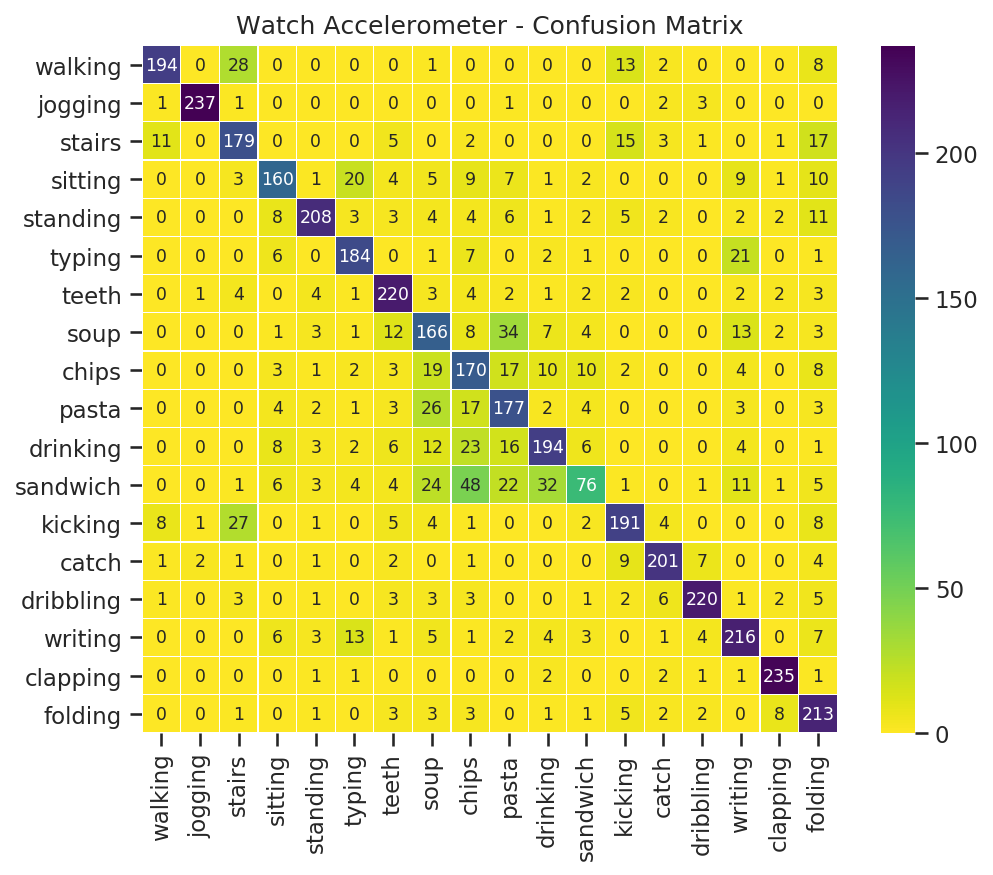

In [46]:
cm1 = generate_confusion_matrix(accel_watch_rf_prediction_array, 'Watch Accelerometer - Confusion Matrix')
cm1

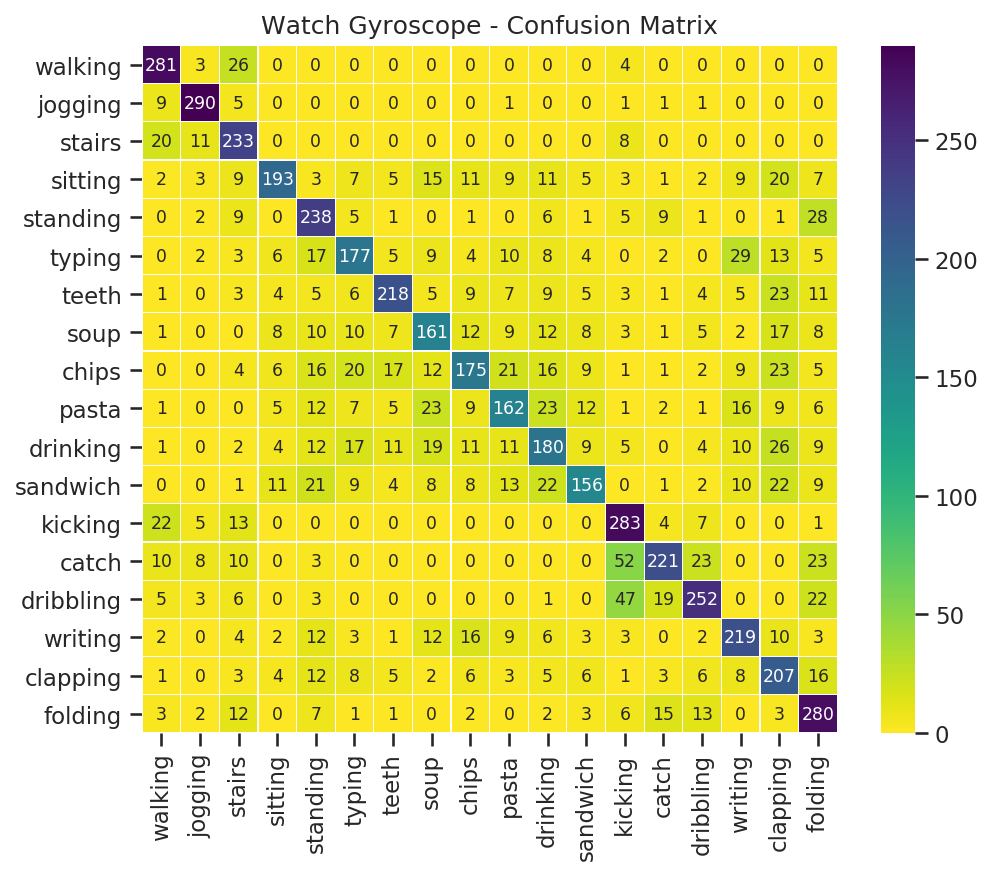

In [47]:
cm2 = generate_confusion_matrix(gyro_watch_rf_prediction_array, 'Watch Gyroscope - Confusion Matrix')
cm2

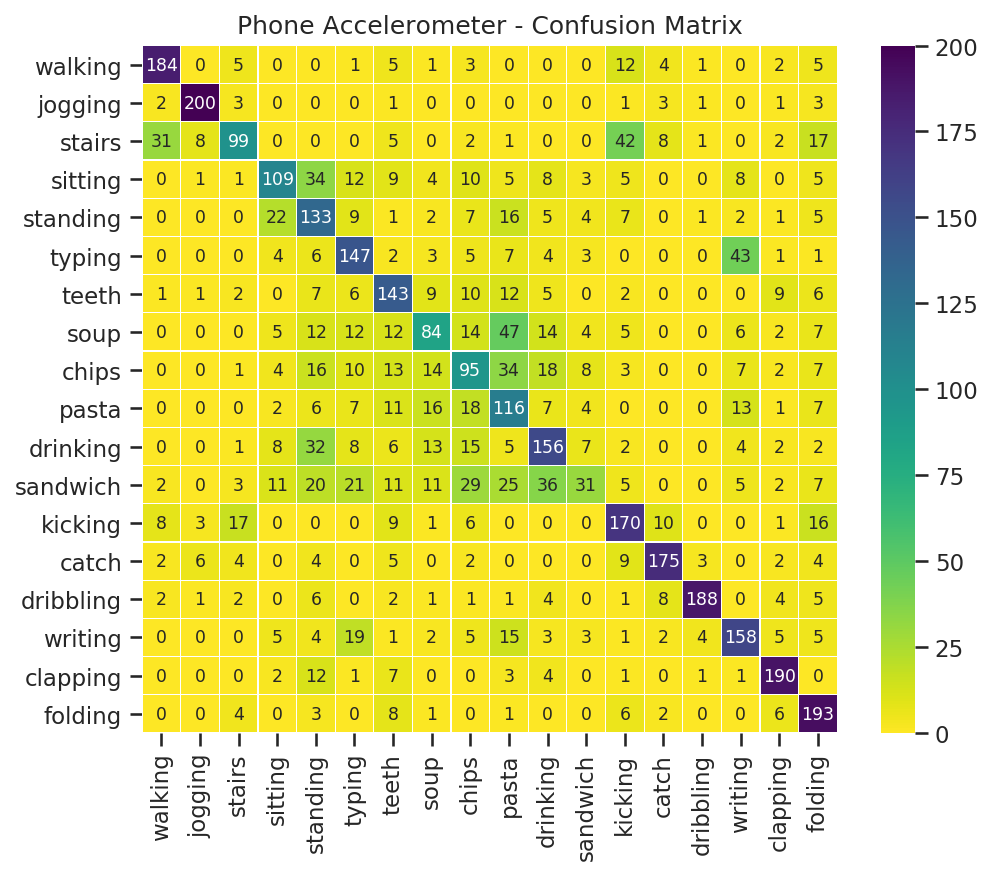

In [48]:
cm3 = generate_confusion_matrix(accel_phone_rf_prediction_array, 'Phone Accelerometer - Confusion Matrix')
cm3

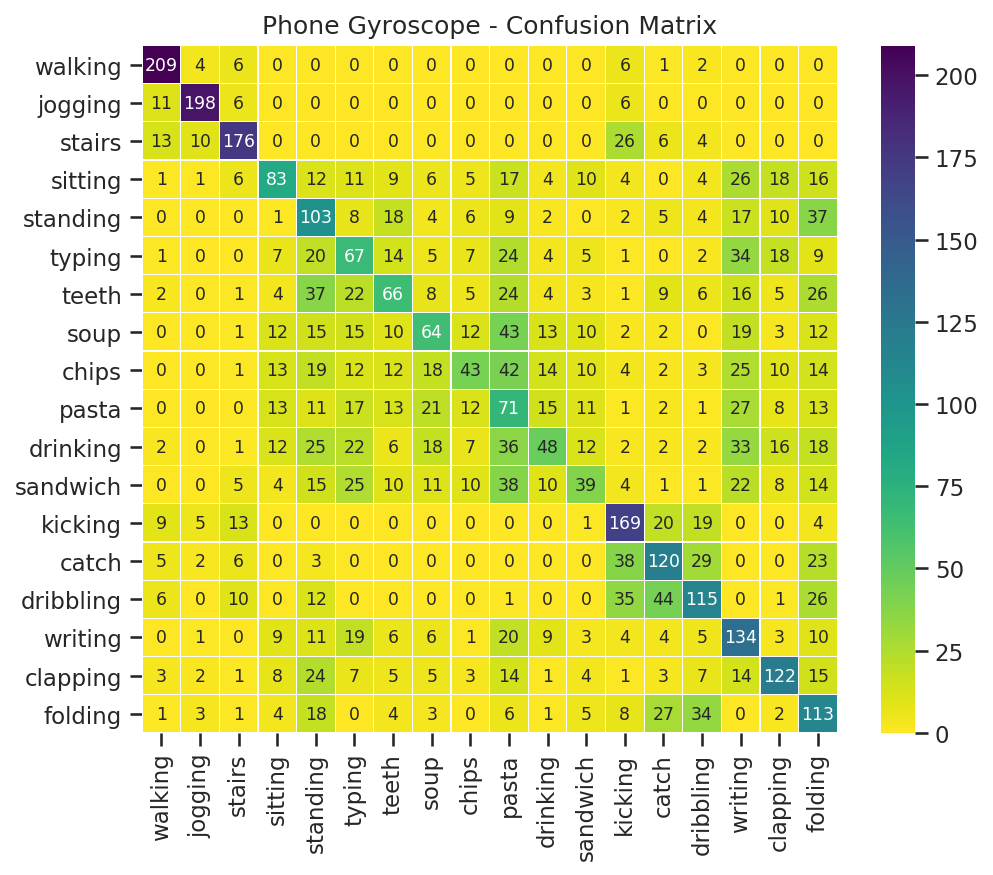

In [49]:
cm4 = generate_confusion_matrix(gyro_phone_rf_prediction_array, 'Phone Gyroscope - Confusion Matrix')
cm4

## Stop Spark Session

In [ ]:
spark.stop()